Doc2vec is an NLP tool for representing documents as a vector and is a generalizing of the word2vec method.

Following: https://towardsdatascience.com/multi-class-text-classification-with-doc2vec-logistic-regression-9da9947b43f4 & https://github.com/practical-nlp/practical-nlp-code/blob/master/Ch4/02_Doc2Vec_Example.ipynb

In [3]:
import os
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import multiprocessing
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
import nltk
from nltk.corpus import stopwords
from string import punctuation
from sklearn import utils
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from gensim.models import Doc2Vec
import gensim
from gensim.models.doc2vec import TaggedDocument

### Get the data

In [2]:
data_fp = 'DATAPATH/complaints.csv'
if not os.path.exists(data_fp):
    !wget -P DATAPATH https://files.consumerfinance.gov/ccdb/complaints.csv.zip
    !unzip DATAPATH/complaints.csv.zip

### Read the data

In [4]:
df = pd.read_csv(data_fp)
df = df[['Consumer complaint narrative','Product']]
df = df[pd.notnull(df['Consumer complaint narrative'])]
df.rename(columns = {'Consumer complaint narrative':'narrative'}, inplace = True)
display(df.head())
# sort the indexes 
df.index = range(df.shape[0])

,narrative,Product
1,I contacted Ally on Friday XX/XX/XXXX after fa...,Vehicle loan or lease
4,I am a victim of Identity Theft & currently ha...,"Credit reporting, credit repair services, or o..."
6,Hello This complaint is against the three cred...,"Credit reporting, credit repair services, or o..."
12,"Dear XXXX, US Bank uses overdrafts in every wa...",Checking or savings account
15,Two accounts are still on my credit history af...,"Credit reporting, credit repair services, or o..."


### EDA

Number of words in corpus: 150113752


/home/rachel/miniconda3/envs/nlp-genism/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


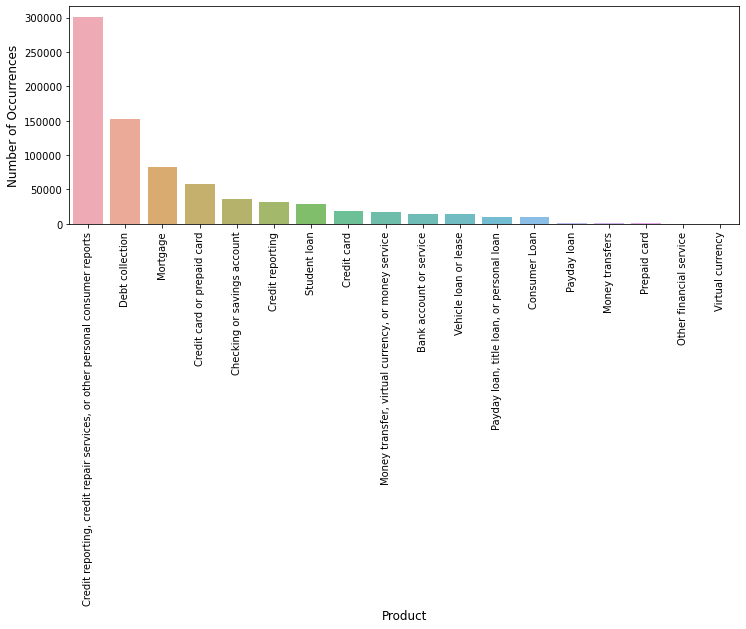

In [5]:
print(f'Number of words in corpus: {df["narrative"].apply(lambda x: len(x.split(" "))).sum()}')
cnt_pro = df['Product'].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(cnt_pro.index, cnt_pro.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Product', fontsize=12)
plt.xticks(rotation=90)
plt.show();

In [6]:
def print_complaint(index):
    example = df[df.index == index][['narrative', 'Product']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Product:', example[1])
print_complaint(0)
print('\n')
print_complaint(20)

I contacted Ally on Friday XX/XX/XXXX after falling behind on payments due to being out of work for a short period of time due to an illness. I chated with a representative after logging into my account regarding my opitions to ensure I protect my credit and bring my account current. 

She advised me that before an extenstion could be done, I had to make a payment in the amount of {$270.00}. I reviewed my finances, as I am playing catch up on all my bills and made this payment on Monday XX/XX/XXXX. This rep advised me, once this payment posts to my account to contact Ally back for an extention or to have a payment deffered to the end of my loan. 

With this in mind, I contacted Ally again today and chatted with XXXX. I explained all of the above and the information I was provided when I chatted with the rep last week. She asked several questions and advised me that a one or two month  extension/deffered payment could be done however partial payment is needed! WHAT? She advised me {$230

### Cleaning Text

In [7]:
def cleanText(text):
#     text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text) 
    text = re.sub(r'http\S+', r'<URL>', text)
    text = text.lower()
    text = text.replace('x', '')
    text = text.replace('//', '')
    return text
df['narrative'] = df['narrative'].apply(cleanText)

### Pre-processing

In [9]:
%%time
train, test = train_test_split(df, test_size=0.3, random_state=42)
# train, test = train_test_split(df.sample(1000, random_state=42), test_size=0.3, random_state=42) 
mystopwords = set(stopwords.words("english"))

def preprocess_corpus(texts):
    def remove_stops_digits(tokens):
        #Nested function that removes stopwords and digits from a list of tokens
        return [token for token in tokens if token not in mystopwords and not token.isdigit() 
                and token not in punctuation]
    #This return statement below uses the above function to process twitter tokenizer output further. 
    return remove_stops_digits(nltk.word_tokenize(texts))

train_tagged = train.apply(
    lambda r: TaggedDocument(words=preprocess_corpus(r['narrative']), tags=[r.Product]), axis=1)
test_tagged = test.apply(
    lambda r: TaggedDocument(words=preprocess_corpus(r['narrative']), tags=[r.Product]), axis=1)

CPU times: user 17min 59s, sys: 20.1 s, total: 18min 19s
Wall time: 18min 20s


In [10]:
train_tagged.values[1]

TaggedDocument(words=['attn', 'collections', 'dept', 'submitting', 'complaint', 'reference', 'company', 'knowingly', 'reporting', 'inaccurate', 'data', 'credit', 'profile', 'affected', 'penalties', 'preventing', 'creditworthiness', 'due', 'companies', 'demand', 'proof', 'purchasing', 'agreement', 'valid', 'authorization/', 'proof', 'alleged', 'debt', 'reporting', 'without', 'valid', 'proper', 'disclosure', 'requirements', 'direct', 'violation', 'consumer', 'rights', 'legally', 'requested', 'description', 'details', 'verification', 'process', 'used', 'verify', 'alleged', 'account', 'federal', 'law', 'requires', 'respond', 'thirty', 'days', 'failure', 'comply', 'federal', 'regulations', 'ftc', 'u.s', 'c41', 'et', 'esq', 'maintaining', 'careful', 'record', 'communication', 'company', 'thank', 'look', 'forward', 'resolving', 'epeditiously'], tags=['Credit reporting, credit repair services, or other personal consumer reports'])

### Feature Engineering; train a Doc2Vec model
Distributed Bag of Words (DBOW)

DBOW is the doc2vec model analogous to Skip-gram model in word2vec.

The paragraph vectors are obtained by training a neural network on the task of predicting a probability distribution of words in a paragraph given a randomly-sampled word from the paragraph.

- `vector_size`: the dimensionality of the learned embeddings
- `alpha` is the learning rate
- `min_count` is the minimum frequency of words that remain in vocabulary
- `dm` (int) stands for {0: distributed bag of words (skip-gram), 1: distributed memory}
- `epochs` are the number of training iterations

Model training takes 2hours:

In [14]:
%%time
model_dir = f'{os.getcwd()}/models'
os.makedirs(model_dir, exist_ok=True)  
model_fp = f'{model_dir}/d2v.model'  # create fp for model to save to

if not os.path.exists(model_fp):
    # Building a Vocabulary
    cores = multiprocessing.cpu_count()
    model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores,
                        epochs=100)
    model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])
    model_dbow.train(train_tagged, total_examples=model_dbow.corpus_count, epochs=model_dbow.epochs)
    model_dbow.save(model_fp)
    print('Model Saved')

CPU times: user 1.68 ms, sys: 42 µs, total: 1.72 ms
Wall time: 1.48 ms


In [16]:
%%time
# Infer the feature representation for training and test data using the trained model
model_dbow = Doc2Vec.load(model_fp)

# Building the Final Vector Feature for the Classifier
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=50)) for doc in sents])
    return targets, regressors

y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)

CPU times: user 4h 30min 40s, sys: 11.2 s, total: 4h 30min 51s
Wall time: 4h 31min 1s


It take's a really long time to build the final vector dataset; 4.5hrs

### Model training

In [17]:
%%time
logreg = LogisticRegression(n_jobs=1, C=1e5, max_iter=300, random_state=42)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

/home/rachel/miniconda3/envs/nlp-genism/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


CPU times: user 41min 51s, sys: 16min 14s, total: 58min 5s
Wall time: 10min 46s


### Evaluate model

In [18]:
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

Testing accuracy 0.7540132723736737
Testing F1 score: 0.7400493623455475
